# Section 1 - Node Classification via GCN

Epoch 0, Loss: 0.8395699858665466, Accuracy: 0.14473684210526316
Epoch 10, Loss: 0.6935998797416687, Accuracy: 0.2236842105263158
Epoch 20, Loss: 0.6479611396789551, Accuracy: 0.6644736842105263
Epoch 30, Loss: 0.6076326966285706, Accuracy: 0.7697368421052632
Epoch 40, Loss: 0.5723543763160706, Accuracy: 0.6907894736842105
Epoch 50, Loss: 0.530014157295227, Accuracy: 0.6842105263157895
Epoch 60, Loss: 0.5251615047454834, Accuracy: 0.7171052631578947
Epoch 70, Loss: 0.5017021298408508, Accuracy: 0.7105263157894737
Epoch 80, Loss: 0.485589861869812, Accuracy: 0.7302631578947368
Epoch 90, Loss: 0.46075648069381714, Accuracy: 0.743421052631579
Epoch 100, Loss: 0.45562052726745605, Accuracy: 0.7763157894736842
Epoch 110, Loss: 0.42816004157066345, Accuracy: 0.756578947368421
Epoch 120, Loss: 0.4374198615550995, Accuracy: 0.743421052631579
Epoch 130, Loss: 0.41078945994377136, Accuracy: 0.7763157894736842
Epoch 140, Loss: 0.42835018038749695, Accuracy: 0.756578947368421
Epoch 150, Loss: 0.41

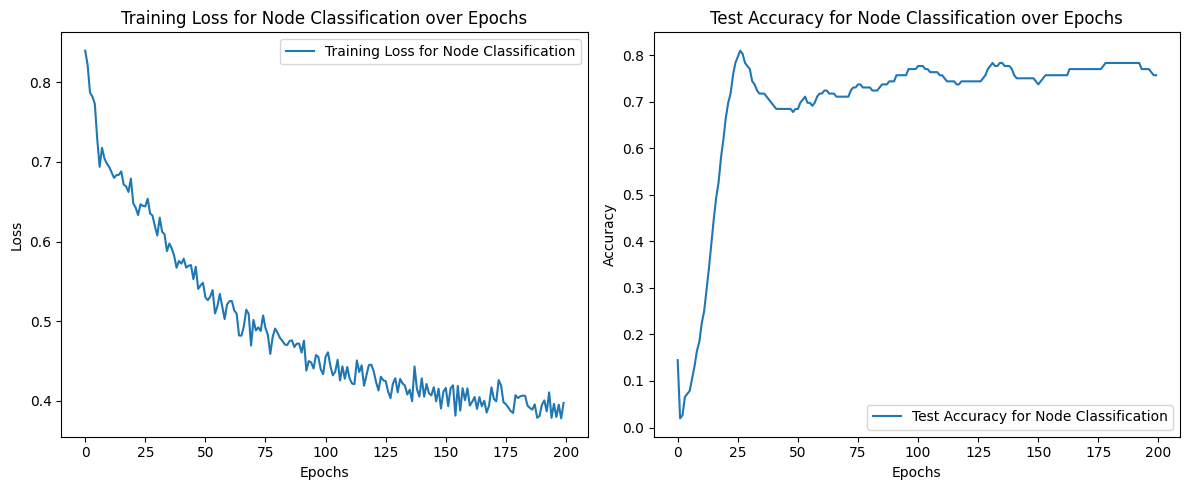

In [2]:
############################# GCN NODE CLASSIFICATION AND PREDICTION SECTION
########################### (loss: the loss of current interations)
############################# (accuracy: rate of properly classifying race per node)

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import os

# Load the dataset
file_path = os.getcwd()
data = pd.read_csv(file_path+"/GNN_Cancer/data/Race_pathways_signatures_meta_short.csv")

# Remove columns with repeated names
data = data.loc[:, ~data.columns.duplicated()]

# Assign binary labels based on race
data['label'] = data['Race'].apply(lambda x: 0 if x == "White (Non-Hispanic)" else 1 if x == "African American" else np.nan)

# Drop rows with NaN labels (if any)
data = data.dropna(subset=['label'])

# Drop non-numeric columns (assuming the first 3 columns are metadata)
gene_expression = data.iloc[:, 1:-1]  # Exclude the race column

# Handle missing values (e.g., fill with the mean of the column)
gene_expression = gene_expression.apply(pd.to_numeric, errors='coerce')
gene_expression = gene_expression.fillna(gene_expression.mean())

# Convert to numpy array
gene_expression = gene_expression.values

# Compute correlation matrix
correlation_matrix = np.corrcoef(gene_expression, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7 
edges = np.where(np.abs(correlation_matrix) > threshold)
edges = np.array(edges)  # Convert to a single numpy array
edge_index = torch.tensor(edges, dtype=torch.long)

# Create node features (gene expression levels for 120 genes)
x = torch.tensor(gene_expression, dtype=torch.float)

# Use actual labels from the dataset
y = torch.tensor(data['label'].values, dtype=torch.long)

# Create PyG data object
data = Data(x=x, edge_index=edge_index, y=y)

# Manually split the data into training and test sets
num_train = 1000
num_test = 152

# Create masks for training and test sets
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[:num_train] = True
test_mask[num_train:num_train + num_test] = True

data.train_mask = train_mask
data.test_mask = test_mask

# Define GNN model for node classification
class GCNNodeClassification(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCNNodeClassification, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = torch.nn.BatchNorm1d(hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 2)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize model, loss, and optimizer
model = GCNNodeClassification(num_node_features=data.num_features, hidden_channels=128)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training loop for node classification
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

# Evaluation for node classification
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        return acc

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Train the model
for epoch in range(200):
    loss = train()
    acc = test()
    train_losses.append(loss)
    test_accuracies.append(acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}, Accuracy: {acc}')

# Save the model
torch.save(model.state_dict(), file_path+'/GNN_Cancer/models/gcn_node_classification_model.pth')

# Load the model
model = GCNNodeClassification(num_node_features=data.num_features, hidden_channels=128)
model.load_state_dict(torch.load(file_path+'/GNN_Cancer/models/gcn_node_classification_model.pth'))
model.eval()

# Print the final test accuracy
final_test_accuracy = test()
print(f'Final Test Accuracy: {final_test_accuracy}')

# Plotting the results for node classification
epochs = range(200)

plt.figure(figsize=(12, 5))

# Plot Training Loss for Node Classification
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss for Node Classification')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Node Classification over Epochs')
plt.legend()

# Plot Test Accuracy for Node Classification
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy for Node Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Node Classification over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig(file_path+'/GNN_Cancer/figures/node_classification_loss_accuracy.png')
plt.show()  


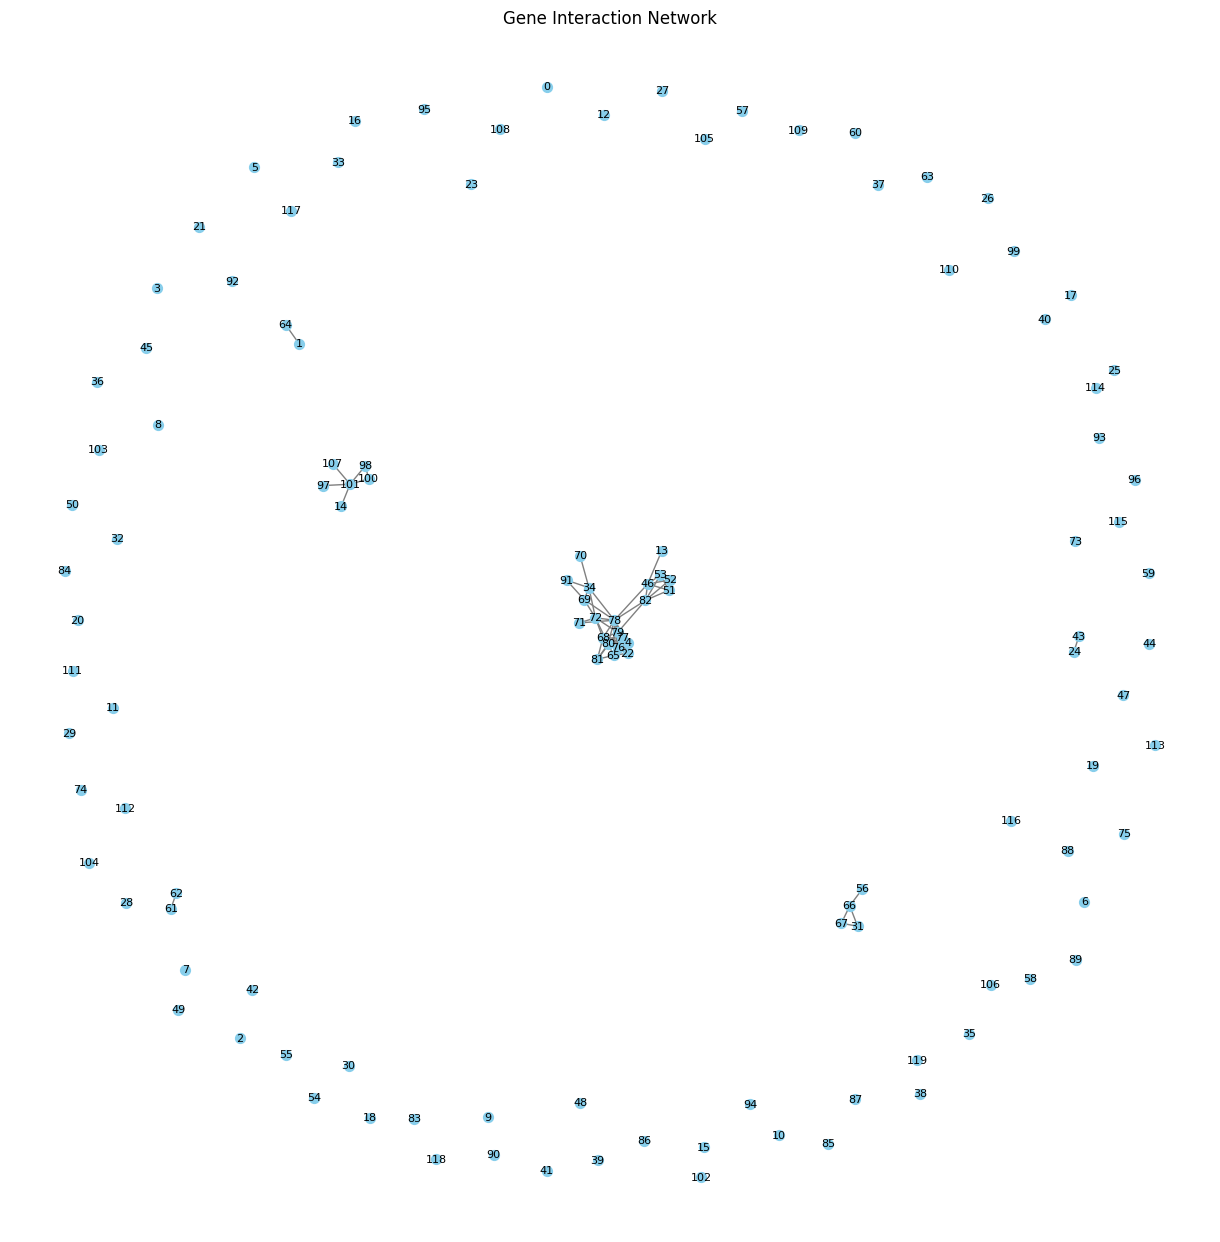

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

# Load the dataset
file_path = os.getcwd()
data = pd.read_csv(file_path+"/GNN_Cancer/data/Race_pathways_signatures_meta_short.csv")

# Assuming gene_expression is already defined and preprocessed
# Compute correlation matrix
correlation_matrix = np.corrcoef(gene_expression, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7
edges = np.where((np.abs(correlation_matrix) > threshold))

# Filter out self-loops
filtered_edges = [(i, j) for i, j in zip(edges[0], edges[1]) if i != j]
edge_index = torch.tensor(filtered_edges, dtype=torch.long).t().contiguous()

# Create a NetworkX graph
G = nx.Graph()

# Add nodes (genes)
num_genes = correlation_matrix.shape[0]
G.add_nodes_from(range(num_genes))

# Add edges based on the correlation threshold
G.add_edges_from(filtered_edges)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Position nodes using the spring layout
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray', font_size=8)
plt.title('Gene Interaction Network')
plt.show()

# Section 2 - Link Prediction via GCN (SPLIT BY RACE)

### African American Link Prediction

Total number of positive training edges (AA): 244
Total number of negative training edges (AA): 244
Total number of positive testing edges (AA): 27
Total number of negative testing edges (AA): 27
Epoch 0, Link Prediction Loss (AA): 0.7102649211883545, Link Prediction Accuracy (AA): 0.5
Epoch 10, Link Prediction Loss (AA): 0.5867916345596313, Link Prediction Accuracy (AA): 0.5
Epoch 20, Link Prediction Loss (AA): 0.4395985007286072, Link Prediction Accuracy (AA): 0.5740740740740741
Epoch 30, Link Prediction Loss (AA): 0.3812406063079834, Link Prediction Accuracy (AA): 0.7222222222222222
Epoch 40, Link Prediction Loss (AA): 0.3036007583141327, Link Prediction Accuracy (AA): 0.6851851851851852
Epoch 50, Link Prediction Loss (AA): 0.2732275724411011, Link Prediction Accuracy (AA): 0.6666666666666666
Epoch 60, Link Prediction Loss (AA): 0.18828772008419037, Link Prediction Accuracy (AA): 0.7037037037037037
Epoch 70, Link Prediction Loss (AA): 0.1581648588180542, Link Prediction Accuracy (AA

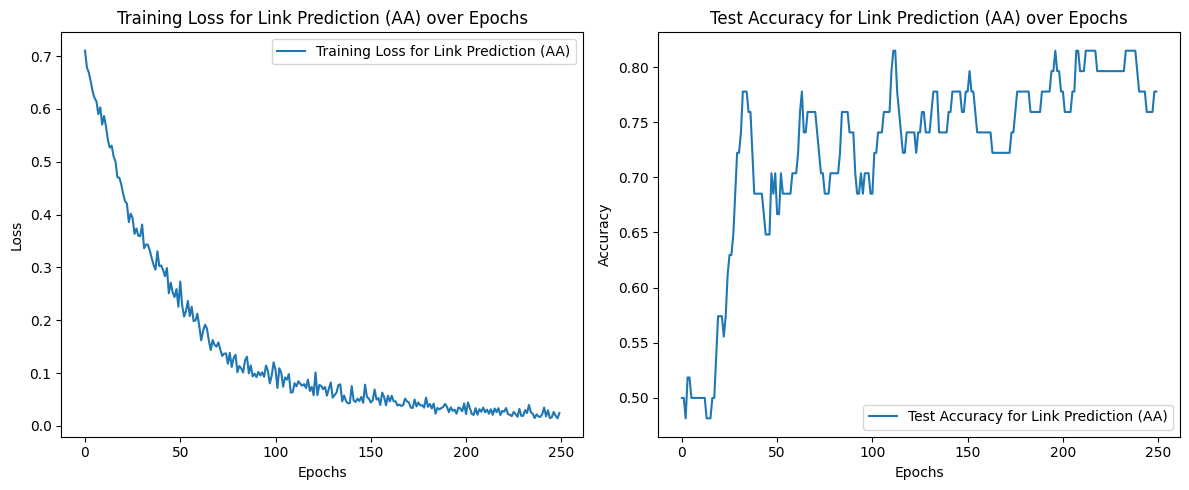

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os

# Load the dataset
file_path = os.getcwd()
data = pd.read_csv(file_path+"/GNN_Cancer/data/Race_pathways_signatures_meta_short.csv")

# Remove columns with repeated names
data = data.loc[:, ~data.columns.duplicated()]

# Assign binary labels based on race
data['label'] = data['Race'].apply(lambda x: 0 if x == "White (Non-Hispanic)" else 1 if x == "African American" else np.nan)

# Drop rows with NaN labels (if any)
data = data.dropna(subset=['label'])

# Filter data for African American individuals
data_aa = data[data['Race'] == "African American"]

# Drop non-numeric columns (race)
gene_expression_aa = data_aa.iloc[:, 1:-2]  # Exclude the race and label columns

# Handle missing values (e.g., fill with the mean of the column)
gene_expression_aa = gene_expression_aa.apply(pd.to_numeric, errors='coerce')
gene_expression_aa = gene_expression_aa.fillna(gene_expression_aa.mean())

# Convert to numpy array
gene_expression_aa = gene_expression_aa.values

# Compute correlation matrix
correlation_matrix_aa = np.corrcoef(gene_expression_aa, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7
edges_aa = np.where(np.abs(correlation_matrix_aa) > threshold)

# Convert the list of numpy arrays to a single numpy array
edges_aa = np.array(edges_aa)

# Create edge_index tensor
edge_index_aa = torch.tensor(edges_aa, dtype=torch.long)

# Create node features (gene expression levels)
x_aa = torch.tensor(gene_expression_aa, dtype=torch.float)

# Use actual labels from the dataset
y_aa = torch.tensor(data_aa['label'].values, dtype=torch.long)

# Create PyG data object
data_aa = Data(x=x_aa, edge_index=edge_index_aa, y=y_aa)

# Split edge set for training and testing
u_aa, v_aa = edge_index_aa
eids_aa = np.arange(edge_index_aa.size(1))
eids_aa = np.random.permutation(eids_aa)
test_size_aa = int(len(eids_aa) * 0.1)
train_size_aa = len(eids_aa) - test_size_aa
test_pos_u_aa, test_pos_v_aa = u_aa[eids_aa[:test_size_aa]], v_aa[eids_aa[:test_size_aa]]
train_pos_u_aa, train_pos_v_aa = u_aa[eids_aa[test_size_aa:]], v_aa[eids_aa[test_size_aa:]]

# Find all negative edges and split them for training and testing
adj_aa = sp.coo_matrix((np.ones(len(u_aa)), (u_aa.numpy(), v_aa.numpy())), shape=(data_aa.num_nodes, data_aa.num_nodes))
adj_neg_aa = 1 - adj_aa.todense() - np.eye(data_aa.num_nodes)
neg_u_aa, neg_v_aa = np.where(adj_neg_aa != 0)

neg_eids_aa = np.random.choice(len(neg_u_aa), len(eids_aa))
test_neg_u_aa, test_neg_v_aa = neg_u_aa[neg_eids_aa[:test_size_aa]], neg_v_aa[neg_eids_aa[:test_size_aa]]
train_neg_u_aa, train_neg_v_aa = neg_u_aa[neg_eids_aa[test_size_aa:]], neg_v_aa[neg_eids_aa[test_size_aa:]]

# Combine positive and negative edges for training
train_edge_index_aa = torch.tensor(np.vstack((np.hstack((train_pos_u_aa, train_neg_u_aa)), np.hstack((train_pos_v_aa, train_neg_v_aa)))), dtype=torch.long)
train_edge_labels_aa = torch.cat([torch.ones(train_size_aa), torch.zeros(train_size_aa)], dim=0).unsqueeze(1)

# Combine positive and negative edges for testing
test_edge_index_aa = torch.tensor(np.vstack((np.hstack((test_pos_u_aa, test_neg_u_aa)), np.hstack((test_pos_v_aa, test_neg_v_aa)))), dtype=torch.long)
test_edge_labels_aa = torch.cat([torch.ones(test_size_aa), torch.zeros(test_size_aa)], dim=0).unsqueeze(1)

# Print the total number of positive and negative edges
train_size_pos_aa = len(train_pos_u_aa)
train_size_neg_aa = len(train_neg_u_aa)
test_size_pos_aa = len(test_pos_u_aa)
test_size_neg_aa = len(test_neg_u_aa)

print(f'Total number of positive training edges (AA): {train_size_pos_aa}')
print(f'Total number of negative training edges (AA): {train_size_neg_aa}')
print(f'Total number of positive testing edges (AA): {test_size_pos_aa}')
print(f'Total number of negative testing edges (AA): {test_size_neg_aa}')

# Define GNN model for node classification
class GCNNodeClassification(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCNNodeClassification, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = torch.nn.BatchNorm1d(hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 2)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

# Define MLP model for link prediction
class MLPLinkPrediction(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(MLPLinkPrediction, self).__init__()
        self.gcn = GCNNodeClassification(num_node_features, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index, edge_index_pos, edge_index_neg):
        x = self.gcn(x, edge_index)
        pos_edge_embeddings = torch.cat([x[edge_index_pos[0]], x[edge_index_pos[1]]], dim=1)
        neg_edge_embeddings = torch.cat([x[edge_index_neg[0]], x[edge_index_neg[1]]], dim=1)
        edge_embeddings = torch.cat([pos_edge_embeddings, neg_edge_embeddings], dim=0)
        x = F.relu(self.fc1(edge_embeddings))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer for link prediction
model_link_pred_aa = MLPLinkPrediction(num_node_features=data_aa.num_features, hidden_channels=64)
criterion_link_pred_aa = torch.nn.BCEWithLogitsLoss()
optimizer_link_pred_aa = torch.optim.Adam(model_link_pred_aa.parameters(), lr=0.0015)

# Training loop for link prediction
def train_link_prediction_aa():
    model_link_pred_aa.train()
    optimizer_link_pred_aa.zero_grad()
    out = model_link_pred_aa(data_aa.x, data_aa.edge_index, train_edge_index_aa[:, :train_size_pos_aa], train_edge_index_aa[:, train_size_pos_aa:])
    loss = criterion_link_pred_aa(out, train_edge_labels_aa)
    loss.backward()
    optimizer_link_pred_aa.step()
    return loss.item()

# Evaluation for link prediction
def test_link_prediction_aa():
    model_link_pred_aa.eval()
    with torch.no_grad():
        out = model_link_pred_aa(data_aa.x, data_aa.edge_index, test_edge_index_aa[:, :test_size_pos_aa], test_edge_index_aa[:, test_size_pos_aa:])
        pred = torch.sigmoid(out)
        pred_labels = (pred > 0.5).float()
        correct = (pred_labels == test_edge_labels_aa).sum()
        acc = int(correct) / len(test_edge_labels_aa)
        return acc, pred

# Store loss and accuracy for plotting
train_losses_link_pred_aa = []
test_accuracies_link_pred_aa = []

# Train the link prediction model
for epoch in range(250):
    loss = train_link_prediction_aa()
    acc, _ = test_link_prediction_aa()
    train_losses_link_pred_aa.append(loss)
    test_accuracies_link_pred_aa.append(acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Link Prediction Loss (AA): {loss}, Link Prediction Accuracy (AA): {acc}')

# Save the link prediction model
torch.save(model_link_pred_aa.state_dict(), file_path+'/GNN_Cancer/models/mlp_link_prediction_model_aa.pth')

# Load the link prediction model
model_link_pred_aa = MLPLinkPrediction(num_node_features=data_aa.num_features, hidden_channels=64)
model_link_pred_aa.load_state_dict(torch.load(file_path+'/GNN_Cancer/models/mlp_link_prediction_model_aa.pth'))
model_link_pred_aa.eval()

# Print the final test accuracy for link prediction and get confidence scores
final_test_accuracy_link_pred_aa, confidence_scores_aa = test_link_prediction_aa()
print(f'Final Test Accuracy for Link Prediction (AA): {final_test_accuracy_link_pred_aa}')

# Plotting the results for link prediction
epochs = range(250)

plt.figure(figsize=(12, 5))

# Plot Training Loss for Link Prediction
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_link_pred_aa, label='Training Loss for Link Prediction (AA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Link Prediction (AA) over Epochs')
plt.legend()

# Plot Test Accuracy for Link Prediction
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies_link_pred_aa, label='Test Accuracy for Link Prediction (AA)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Link Prediction (AA) over Epochs')
plt.legend()    

plt.tight_layout()
plt.savefig(file_path+'/GNN_Cancer/figures/link_prediction_loss_accuracy_aa.png')
plt.show()

### White (Non-Hispanic) Link Prediction

Total number of positive training edges (White): 248
Total number of negative training edges (White): 248
Total number of positive testing edges (White): 27
Total number of negative testing edges (White): 27
Epoch 0, Link Prediction Loss (White): 0.6952369213104248, Link Prediction Accuracy (White): 0.5
Epoch 10, Link Prediction Loss (White): 0.4737664461135864, Link Prediction Accuracy (White): 0.5740740740740741
Epoch 20, Link Prediction Loss (White): 0.38734954595565796, Link Prediction Accuracy (White): 0.48148148148148145
Epoch 30, Link Prediction Loss (White): 0.2898420989513397, Link Prediction Accuracy (White): 0.5740740740740741
Epoch 40, Link Prediction Loss (White): 0.2052524983882904, Link Prediction Accuracy (White): 0.7222222222222222
Epoch 50, Link Prediction Loss (White): 0.18616892397403717, Link Prediction Accuracy (White): 0.7037037037037037
Epoch 60, Link Prediction Loss (White): 0.16567954421043396, Link Prediction Accuracy (White): 0.8148148148148148
Epoch 70, Lin

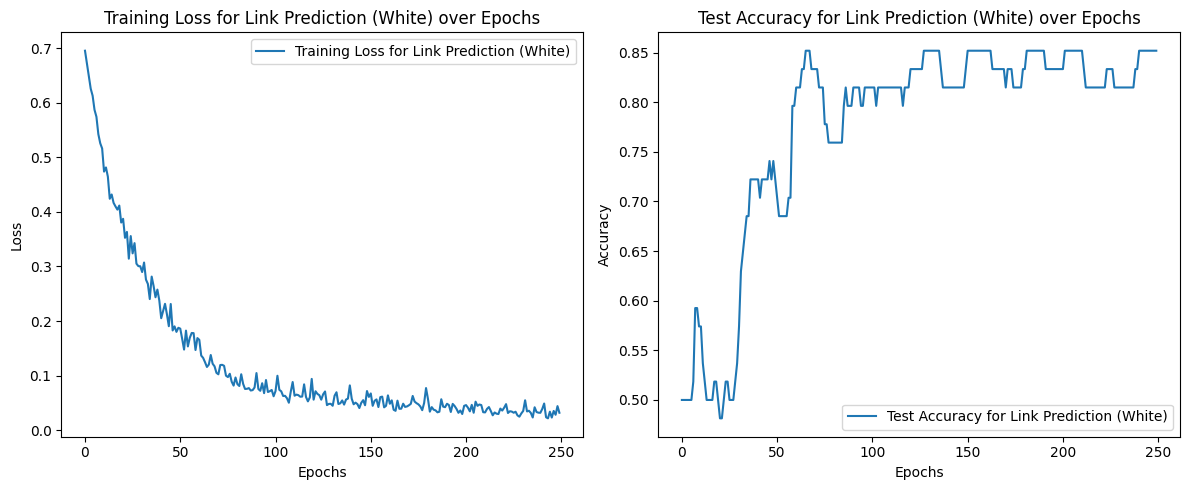

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os

# Load the dataset
file_path = os.getcwd()
data = pd.read_csv(file_path+"/GNN_Cancer/data/Race_pathways_signatures_meta_short.csv")

# Remove columns with repeated names
data = data.loc[:, ~data.columns.duplicated()]

# Assign binary labels based on race
data['label'] = data['Race'].apply(lambda x: 0 if x == "White (Non-Hispanic)" else 1 if x == "African American" else np.nan)

# Drop rows with NaN labels (if any)
data = data.dropna(subset=['label'])

# Filter data for White (Non-Hispanic) individuals
data_white = data[data['Race'] == "White (Non-Hispanic)"]

# Drop non-numeric columns (race)
gene_expression_white = data_white.iloc[:, 1:-2]  # Exclude the race and label columns

# Handle missing values (e.g., fill with the mean of the column)
gene_expression_white = gene_expression_white.apply(pd.to_numeric, errors='coerce')
gene_expression_white = gene_expression_white.fillna(gene_expression_white.mean())

# Convert to numpy array
gene_expression_white = gene_expression_white.values

# Compute correlation matrix
correlation_matrix_white = np.corrcoef(gene_expression_white, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7
edges_white = np.where(np.abs(correlation_matrix_white) > threshold)

# Convert the list of numpy arrays to a single numpy array
edges_white = np.array(edges_white)

# Create edge_index tensor
edge_index_white = torch.tensor(edges_white, dtype=torch.long)

# Create node features (gene expression levels)
x_white = torch.tensor(gene_expression_white, dtype=torch.float)

# Use actual labels from the dataset
y_white = torch.tensor(data_white['label'].values, dtype=torch.long)

# Create PyG data object
data_white = Data(x=x_white, edge_index=edge_index_white, y=y_white)

# Split edge set for training and testing
u_white, v_white = edge_index_white
eids_white = np.arange(edge_index_white.size(1))
eids_white = np.random.permutation(eids_white)
test_size_white = int(len(eids_white) * 0.1)
train_size_white = len(eids_white) - test_size_white
test_pos_u_white, test_pos_v_white = u_white[eids_white[:test_size_white]], v_white[eids_white[:test_size_white]]
train_pos_u_white, train_pos_v_white = u_white[eids_white[test_size_white:]], v_white[eids_white[test_size_white:]]

# Find all negative edges and split them for training and testing
adj_white = sp.coo_matrix((np.ones(len(u_white)), (u_white.numpy(), v_white.numpy())), shape=(data_white.num_nodes, data_white.num_nodes))
adj_neg_white = 1 - adj_white.todense() - np.eye(data_white.num_nodes)
neg_u_white, neg_v_white = np.where(adj_neg_white != 0)

neg_eids_white = np.random.choice(len(neg_u_white), len(eids_white))
test_neg_u_white, test_neg_v_white = neg_u_white[neg_eids_white[:test_size_white]], neg_v_white[neg_eids_white[:test_size_white]]
train_neg_u_white, train_neg_v_white = neg_u_white[neg_eids_white[test_size_white:]], neg_v_white[neg_eids_white[test_size_white:]]

# Combine positive and negative edges for training
train_edge_index_white = torch.tensor(np.vstack((np.hstack((train_pos_u_white, train_neg_u_white)), np.hstack((train_pos_v_white, train_neg_v_white)))), dtype=torch.long)
train_edge_labels_white = torch.cat([torch.ones(train_size_white), torch.zeros(train_size_white)], dim=0).unsqueeze(1)

# Combine positive and negative edges for testing
test_edge_index_white = torch.tensor(np.vstack((np.hstack((test_pos_u_white, test_neg_u_white)), np.hstack((test_pos_v_white, test_neg_v_white)))), dtype=torch.long)
test_edge_labels_white = torch.cat([torch.ones(test_size_white), torch.zeros(test_size_white)], dim=0).unsqueeze(1)

# Print the total number of positive and negative edges
train_size_pos_white = len(train_pos_u_white)
train_size_neg_white = len(train_neg_u_white)
test_size_pos_white = len(test_pos_u_white)
test_size_neg_white = len(test_neg_u_white)

print(f'Total number of positive training edges (White): {train_size_pos_white}')
print(f'Total number of negative training edges (White): {train_size_neg_white}')
print(f'Total number of positive testing edges (White): {test_size_pos_white}')
print(f'Total number of negative testing edges (White): {test_size_neg_white}')

# Define GNN model for node classification
class GCNNodeClassification(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCNNodeClassification, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = torch.nn.BatchNorm1d(hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 2)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

# Define MLP model for link prediction
class MLPLinkPrediction(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(MLPLinkPrediction, self).__init__()
        self.gcn = GCNNodeClassification(num_node_features, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index, edge_index_pos, edge_index_neg):
        x = self.gcn(x, edge_index)
        pos_edge_embeddings = torch.cat([x[edge_index_pos[0]], x[edge_index_pos[1]]], dim=1)
        neg_edge_embeddings = torch.cat([x[edge_index_neg[0]], x[edge_index_neg[1]]], dim=1)
        edge_embeddings = torch.cat([pos_edge_embeddings, neg_edge_embeddings], dim=0)
        x = F.relu(self.fc1(edge_embeddings))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer for link prediction
model_link_pred_white = MLPLinkPrediction(num_node_features=data_white.num_features, hidden_channels=64)
criterion_link_pred_white = torch.nn.BCEWithLogitsLoss()
optimizer_link_pred_white = torch.optim.Adam(model_link_pred_white.parameters(), lr=0.0015)

# Training loop for link prediction
def train_link_prediction_white():
    model_link_pred_white.train()
    optimizer_link_pred_white.zero_grad()
    out = model_link_pred_white(data_white.x, data_white.edge_index, train_edge_index_white[:, :train_size_pos_white], train_edge_index_white[:, train_size_pos_white:])
    loss = criterion_link_pred_white(out, train_edge_labels_white)
    loss.backward()
    optimizer_link_pred_white.step()
    return loss.item()

# Evaluation for link prediction
def test_link_prediction_white():
    model_link_pred_white.eval()
    with torch.no_grad():
        out = model_link_pred_white(data_white.x, data_white.edge_index, test_edge_index_white[:, :test_size_pos_white], test_edge_index_white[:, test_size_pos_white:])
        pred = torch.sigmoid(out)
        pred_labels = (pred > 0.5).float()
        correct = (pred_labels == test_edge_labels_white).sum()
        acc = int(correct) / len(test_edge_labels_white)
        return acc, pred

# Store loss and accuracy for plotting
train_losses_link_pred_white = []
test_accuracies_link_pred_white = []

# Train the link prediction model
for epoch in range(250):
    loss = train_link_prediction_white()
    acc, _ = test_link_prediction_white()
    train_losses_link_pred_white.append(loss)
    test_accuracies_link_pred_white.append(acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Link Prediction Loss (White): {loss}, Link Prediction Accuracy (White): {acc}')

# Save the link prediction model
torch.save(model_link_pred_white.state_dict(), file_path+'/GNN_Cancer/models/mlp_link_prediction_model_white.pth')

# Load the link prediction model
model_link_pred_white = MLPLinkPrediction(num_node_features=data_white.num_features, hidden_channels=64)
model_link_pred_white.load_state_dict(torch.load(file_path+'/GNN_Cancer/models/mlp_link_prediction_model_white.pth'))
model_link_pred_white.eval()

# Print the final test accuracy for link prediction and get confidence scores
final_test_accuracy_link_pred_white, confidence_scores_white = test_link_prediction_white()
print(f'Final Test Accuracy for Link Prediction (White): {final_test_accuracy_link_pred_white}')

# Plotting the results for link prediction
epochs = range(250)

plt.figure(figsize=(12, 5))

# Plot Training Loss for Link Prediction
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_link_pred_white, label='Training Loss for Link Prediction (White)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Link Prediction (White) over Epochs')
plt.legend()

# Plot Test Accuracy for Link Prediction
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies_link_pred_white, label='Test Accuracy for Link Prediction (White)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Link Prediction (White) over Epochs')
plt.legend()    

plt.tight_layout()
plt.savefig(file_path+'/GNN_Cancer/figures/link_prediction_loss_accuracy_white.png')
plt.show()

### Values of Significance + High Confidence Interactions

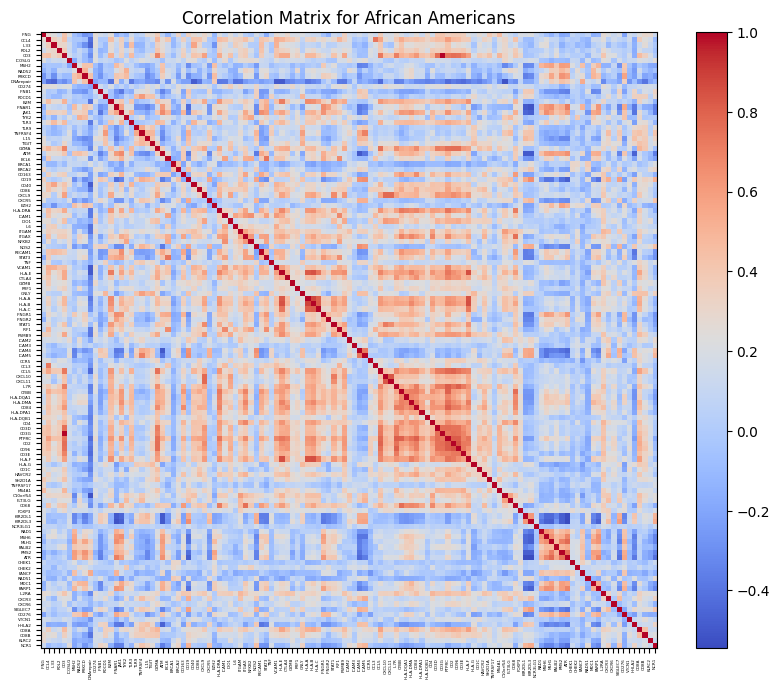

/home/arifai/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


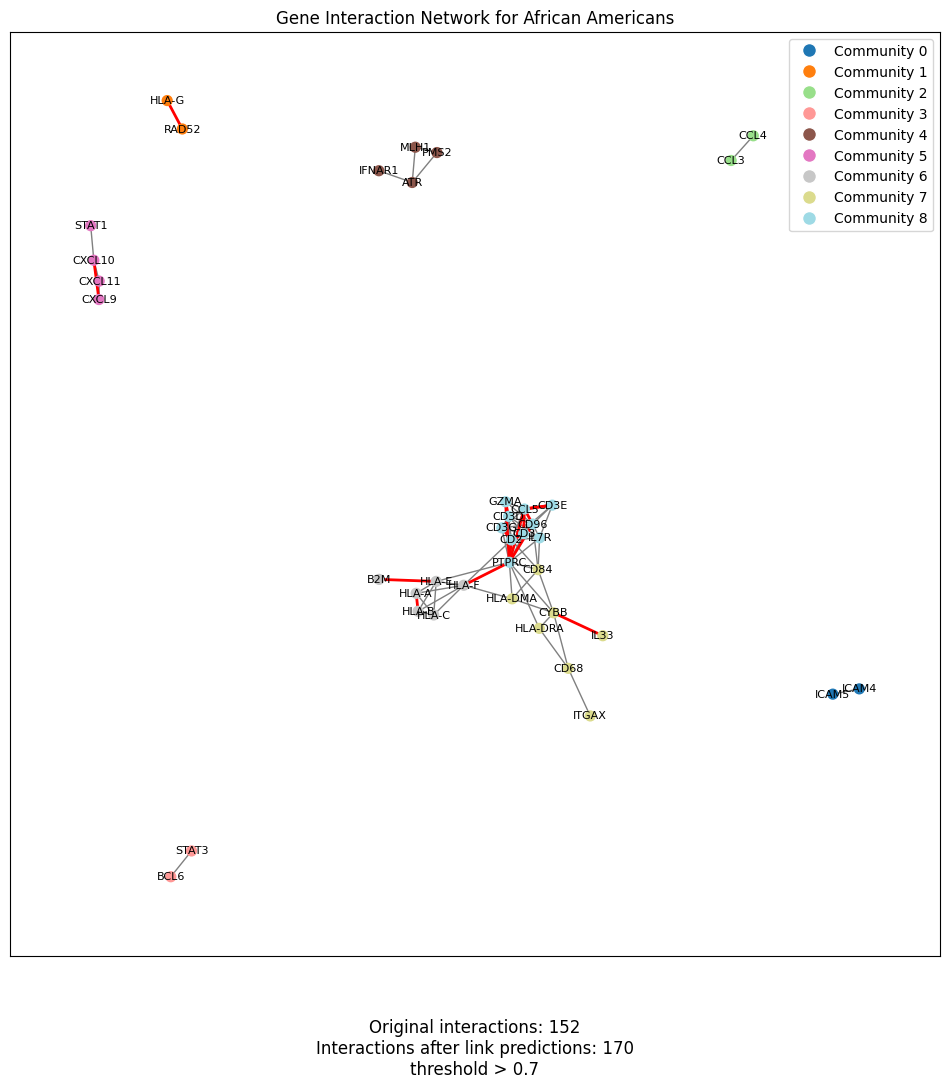

Degree Centrality for African Americans: {'CCL4': 0.02631578947368421, 'IL33': 0.02631578947368421, 'CD3': 0.18421052631578946, 'RAD52': 0.02631578947368421, 'B2M': 0.02631578947368421, 'IFNAR1': 0.02631578947368421, 'GZMA': 0.13157894736842105, 'BCL6': 0.02631578947368421, 'CXCL9': 0.05263157894736842, 'HLA-DRA': 0.07894736842105263, 'ITGAX': 0.02631578947368421, 'STAT3': 0.02631578947368421, 'HLA-E': 0.15789473684210525, 'HLA-A': 0.10526315789473684, 'HLA-B': 0.10526315789473684, 'HLA-C': 0.10526315789473684, 'STAT1': 0.02631578947368421, 'ICAM4': 0.02631578947368421, 'ICAM5': 0.02631578947368421, 'CCL3': 0.02631578947368421, 'CCL5': 0.21052631578947367, 'CXCL10': 0.07894736842105263, 'CXCL11': 0.05263157894736842, 'IL7R': 0.21052631578947367, 'CYBB': 0.15789473684210525, 'HLA-DMA': 0.10526315789473684, 'CD84': 0.15789473684210525, 'CD3D': 0.21052631578947367, 'CD3G': 0.18421052631578946, 'PTPRC': 0.3684210526315789, 'CD2': 0.2894736842105263, 'CD96': 0.2631578947368421, 'CD3E': 0.10

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import torch
import community as community_louvain
from matplotlib.lines import Line2D

# Load the dataset
file_path = os.getcwd()
data = pd.read_csv(file_path + "/GNN_Cancer/data/Race_pathways_signatures_meta_short.csv")

# Remove columns with repeated names
data = data.loc[:, ~data.columns.duplicated()]

# Filter data for African Americans
df_aa = data[data['Race'] == "African American"]

# Extract gene names from the original DataFrame
gene_names = df_aa.columns[1:-1]

# Drop non-numeric columns (race)
gene_expression_aa = df_aa.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in gene expression data
gene_expression_aa = gene_expression_aa.dropna()

# Function to visualize the correlation matrix
def visualize_correlation_matrix(correlation_matrix, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(gene_names)), labels=gene_names, rotation=90, fontsize=3)
    plt.yticks(ticks=np.arange(len(gene_names)), labels=gene_names, fontsize=3)
    plt.title(title)
    plt.show()

# Perform analysis for African Americans
race_corr_matrix_aa = np.corrcoef(gene_expression_aa.values, rowvar=False)
visualize_correlation_matrix(race_corr_matrix_aa, "Correlation Matrix for African Americans")

# Visualization section
# Compute correlation matrix
correlation_matrix = np.corrcoef(gene_expression_aa.values, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7
edges = np.where((np.abs(correlation_matrix) > threshold))

# Filter out self-loops
filtered_edges = [(i, j) for i, j in zip(edges[0], edges[1]) if i != j]
edge_index = torch.tensor(filtered_edges, dtype=torch.long).t().contiguous()

# Create a NetworkX graph
G = nx.Graph()

# Add nodes (genes)
num_genes = correlation_matrix.shape[0]
G.add_nodes_from(range(num_genes))

# Add edges based on the correlation threshold
G.add_edges_from(filtered_edges)

# Count the number of original interactions
original_interactions_count_aa = len(filtered_edges)

# Get the top interactions with the highest confidence scores for African Americans
confidence_scores_aa = confidence_scores_aa.squeeze()
top_indices_aa = np.argsort(confidence_scores_aa)[-20:][::1]
top_scores_aa = confidence_scores_aa[top_indices_aa]

# Convert test_edge_index_aa to numpy array and make a copy to avoid negative strides issue
test_edge_index_aa_np = test_edge_index_aa.numpy().copy()
top_interactions_aa = test_edge_index_aa_np[:, top_indices_aa].T

# Add predicted links/edges
interaction_count_aa = 0
predicted_edges = []
for interaction in top_interactions_aa:
    if interaction[0] != interaction[1]:
        G.add_edge(interaction[0], interaction[1])
        predicted_edges.append((interaction[0], interaction[1]))
        interaction_count_aa += 1

# Remove nodes without any edges
nodes_without_edges = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(nodes_without_edges)

# Community detection using the Louvain method
partition = community_louvain.best_partition(G)

# Sort communities to keep the community numbers consistent
sorted_communities = sorted(set(partition.values()), key=lambda x: (list(partition.values()).count(x), x))
community_mapping = {old: new for new, old in enumerate(sorted_communities)}
partition = {node: community_mapping[community] for node, community in partition.items()}

# Assign colors to communities
community_colors = {}
unique_communities = set(partition.values())
color_map = plt.get_cmap('tab20', len(unique_communities))

for i, community in enumerate(unique_communities):
    community_colors[community] = color_map(i)

# Plot the graph with community labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Position nodes using the spring layout

# Draw nodes with colors based on their community
node_colors = [community_colors[partition[node]] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, cmap=color_map)

# Draw original edges
original_edges = [edge for edge in G.edges() if edge not in predicted_edges]
nx.draw_networkx_edges(G, pos, edgelist=original_edges, edge_color='gray')

# Draw predicted edges in red
nx.draw_networkx_edges(G, pos, edgelist=predicted_edges, edge_color='red', width=2)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={i: gene_names[i] for i in G.nodes()}, font_size=8)

# Create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Community {community}', 
                          markerfacecolor=color_map(i), markersize=10) for i, community in enumerate(unique_communities)]
plt.legend(handles=legend_elements, loc='best')

# Add text at the bottom middle
plt.text(0.5, -0.1, f"Original interactions: {original_interactions_count_aa}\nInteractions after link predictions: {original_interactions_count_aa + interaction_count_aa}\nthreshold > 0.7", 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.title('Gene Interaction Network for African Americans')
plt.show()

# Centrality and community detection analysis
race_name = "African Americans"

# Degree centrality
degree_centrality = nx.degree_centrality(G)
degree_centrality_named = {gene_names[gene]: value for gene, value in degree_centrality.items()}
print(f"Degree Centrality for {race_name}:", degree_centrality_named)

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_named = {gene_names[gene]: value for gene, value in betweenness_centrality.items()}
print(f"Betweenness Centrality for {race_name}:", betweenness_centrality_named)

# Closeness centrality
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality_named = {gene_names[gene]: value for gene, value in closeness_centrality.items()}
print(f"Closeness Centrality for {race_name}:", closeness_centrality_named)

# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
eigenvector_centrality_named = {gene_names[gene]: value for gene, value in eigenvector_centrality.items()}
print(f"Eigenvector Centrality for {race_name}:", eigenvector_centrality_named)

# Clustering coefficient
clustering_coefficient = nx.clustering(G)
clustering_coefficient_named = {gene_names[gene]: value for gene, value in clustering_coefficient.items()}
print(f"Clustering Coefficient for {race_name}:", clustering_coefficient_named)

# Community detection using the Louvain method
partition_named = {gene_names[gene]: community for gene, community in partition.items()}
print(f"Community Detection (Louvain) for {race_name}:", partition_named)

# Group genes by their respective community
communities = {}
for gene, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(gene_names[gene])

# Print genes grouped by their respective community
print("\nGenes grouped by their respective community:")
for community, genes in communities.items():
    print(f"Community {community}:")
    print(", ".join(genes))

# Find and print the gene with the highest value for each centrality measure and clustering coefficient
max_degree_gene = max(degree_centrality, key=degree_centrality.get)
max_betweenness_gene = max(betweenness_centrality, key=betweenness_centrality.get)
max_closeness_gene = max(closeness_centrality, key=closeness_centrality.get)
max_eigenvector_gene = max(eigenvector_centrality, key=eigenvector_centrality.get)
max_clustering_gene = max(clustering_coefficient, key=clustering_coefficient.get)

print("\nGenes with the highest centrality measures and clustering coefficient:")
print(f"Highest Degree Centrality: Gene {max_degree_gene} ({gene_names[max_degree_gene]}) with value {degree_centrality[max_degree_gene]}")
print(f"Highest Betweenness Centrality: Gene {max_betweenness_gene} ({gene_names[max_betweenness_gene]}) with value {betweenness_centrality[max_betweenness_gene]}")
print(f"Highest Closeness Centrality: Gene {max_closeness_gene} ({gene_names[max_closeness_gene]}) with value {closeness_centrality[max_closeness_gene]}")
print(f"Highest Eigenvector Centrality: Gene {max_eigenvector_gene} ({gene_names[max_eigenvector_gene]}) with value {eigenvector_centrality[max_eigenvector_gene]}")
print(f"Highest Clustering Coefficient: Gene {max_clustering_gene} ({gene_names[max_clustering_gene]}) with value {clustering_coefficient[max_clustering_gene]}")

print("\nTop interactions with the highest confidence scores for African Americans (low to high):")
printed_interactions_aa = set()

for score, interaction in zip(top_scores_aa, top_interactions_aa):
    interaction_tuple = tuple(interaction)
    reverse_interaction_tuple = tuple(interaction[::-1])
    
    if interaction[0] != interaction[1] and interaction_tuple not in printed_interactions_aa and reverse_interaction_tuple not in printed_interactions_aa:
        printed_interactions_aa.add(interaction_tuple)
        print(f"Interaction ({gene_names[interaction[0]]} - {gene_names[interaction[1]]}) with confidence score {score}")

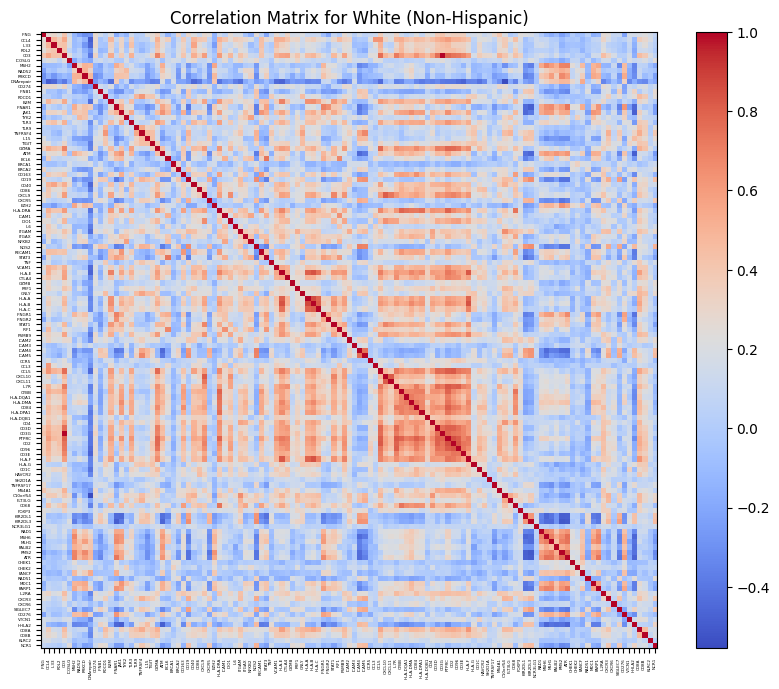

Degree Centrality for White (Non-Hispanic): {4: 0.18421052631578946, 14: 0.02631578947368421, 22: 0.13157894736842105, 23: 0.02631578947368421, 24: 0.02631578947368421, 31: 0.05263157894736842, 34: 0.18421052631578946, 43: 0.02631578947368421, 46: 0.13157894736842105, 48: 0.02631578947368421, 51: 0.10526315789473684, 52: 0.10526315789473684, 53: 0.07894736842105263, 61: 0.02631578947368421, 62: 0.02631578947368421, 65: 0.23684210526315788, 66: 0.05263157894736842, 67: 0.05263157894736842, 68: 0.21052631578947367, 69: 0.13157894736842105, 70: 0.07894736842105263, 71: 0.10526315789473684, 72: 0.15789473684210525, 73: 0.07894736842105263, 76: 0.21052631578947367, 77: 0.18421052631578946, 78: 0.42105263157894735, 79: 0.2894736842105263, 80: 0.23684210526315788, 81: 0.07894736842105263, 82: 0.13157894736842105, 91: 0.05263157894736842, 97: 0.05263157894736842, 98: 0.05263157894736842, 100: 0.02631578947368421, 101: 0.13157894736842105, 103: 0.02631578947368421, 107: 0.02631578947368421, np.

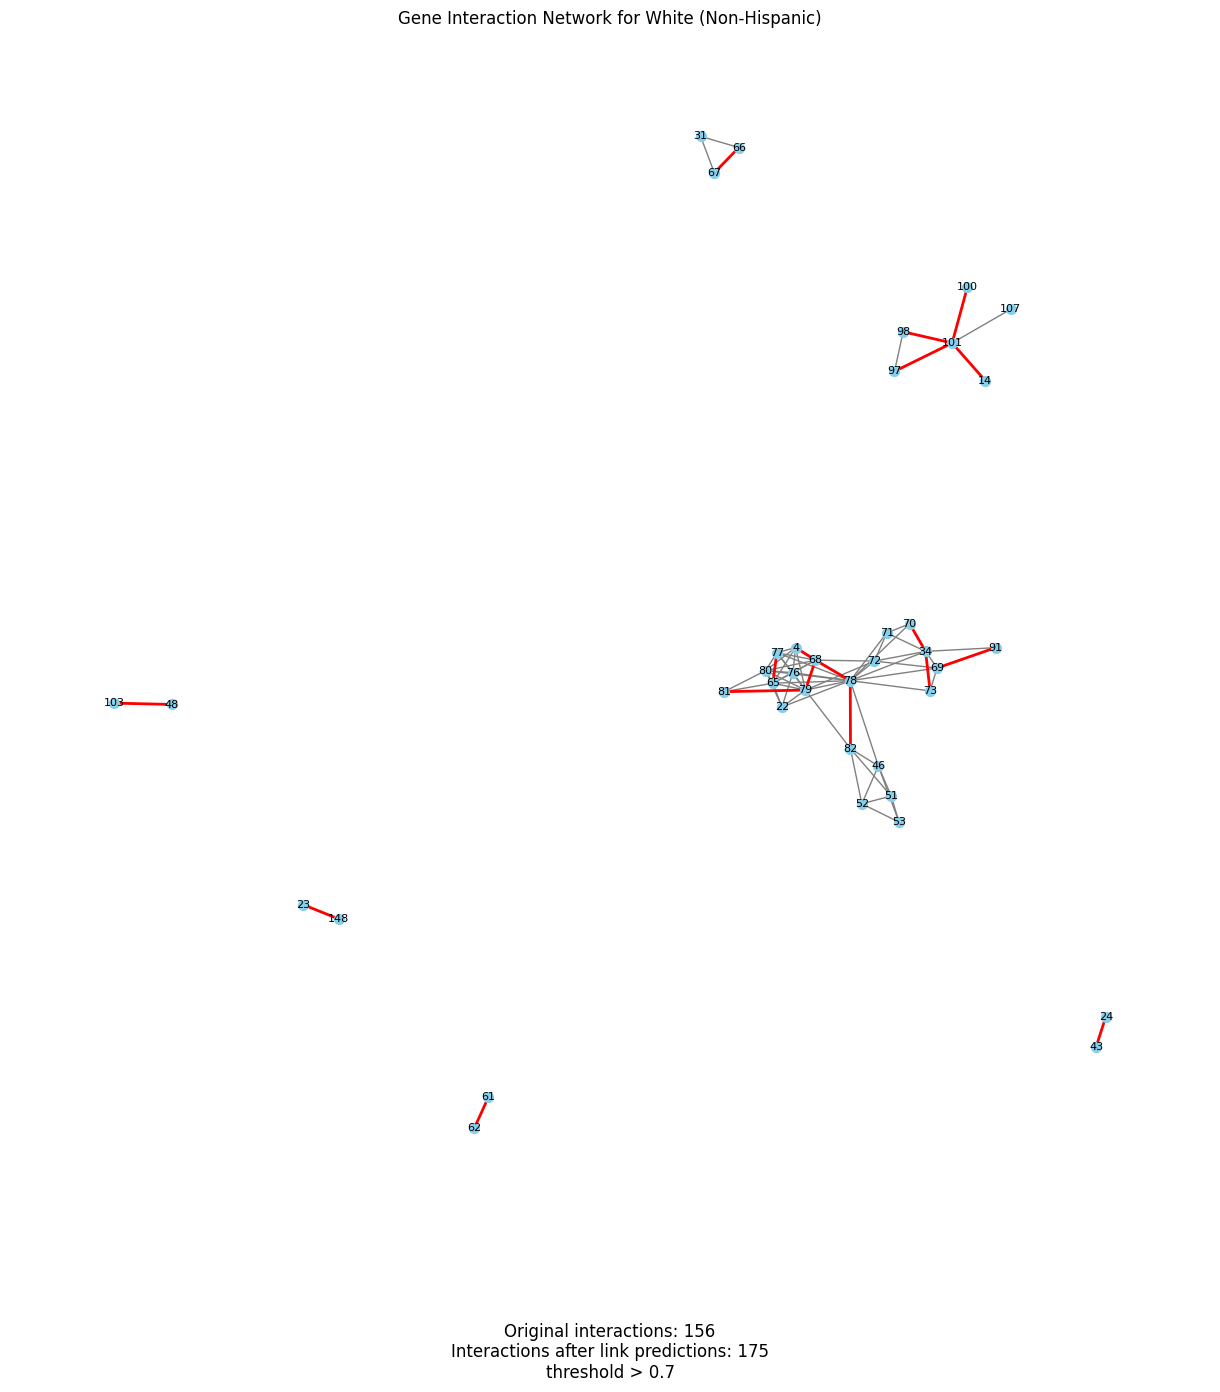

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import torch
import community as community_louvain

# Load the dataset
file_path = os.getcwd()
data = pd.read_csv(file_path + "/GNN_Cancer/data/Race_pathways_signatures_meta_short.csv")

# Remove columns with repeated names
data = data.loc[:, ~data.columns.duplicated()]

# Filter data for White (Non-Hispanic)
df_wh = data[data['Race'] == "White (Non-Hispanic)"]

# Extract gene names from the original DataFrame
gene_names = df_wh.columns[1:-1]

# Drop non-numeric columns (race)
gene_expression_wh = df_wh.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in gene expression data
gene_expression_wh = gene_expression_wh.dropna()

# Function to visualize the correlation matrix
def visualize_correlation_matrix(correlation_matrix, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(gene_names)), labels=gene_names, rotation=90, fontsize=3)
    plt.yticks(ticks=np.arange(len(gene_names)), labels=gene_names, fontsize=3)
    plt.title(title)
    plt.show()

# Perform analysis for White (Non-Hispanic)
race_corr_matrix_wh = np.corrcoef(gene_expression_wh.values, rowvar=False)
visualize_correlation_matrix(race_corr_matrix_wh, "Correlation Matrix for White (Non-Hispanic)")

# Visualization section
# Compute correlation matrix
correlation_matrix = np.corrcoef(gene_expression_wh.values, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7
edges = np.where((np.abs(correlation_matrix) > threshold))

# Filter out self-loops
filtered_edges = [(i, j) for i, j in zip(edges[0], edges[1]) if i != j]
edge_index = torch.tensor(filtered_edges, dtype=torch.long).t().contiguous()

# Create a NetworkX graph
G = nx.Graph()

# Add nodes (genes)
num_genes = correlation_matrix.shape[0]
G.add_nodes_from(range(num_genes))

# Add edges based on the correlation threshold
G.add_edges_from(filtered_edges)

# Count the number of original interactions
original_interactions_count_wh = len(filtered_edges)

# Get the top interactions with the highest confidence scores for Whites
confidence_scores_white = confidence_scores_white.squeeze()
top_indices_white = np.argsort(confidence_scores_white)[-20:][::1]
top_scores_white = confidence_scores_white[top_indices_white]

# Convert test_edge_index_white to numpy array and make a copy to avoid negative strides issue
test_edge_index_white_np = test_edge_index_white.numpy().copy()
top_interactions_white = test_edge_index_white_np[:, top_indices_white].T

# Add predicted links/edges
interaction_count_white = 0
for interaction in top_interactions_white:
    if interaction[0] != interaction[1]:
        G.add_edge(interaction[0], interaction[1])
        interaction_count_white += 1

# Remove nodes without any edges
nodes_without_edges = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(nodes_without_edges)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Position nodes using the spring layout
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray', font_size=8)
plt.title('Gene Interaction Network for White (Non-Hispanic)')

# Centrality and community detection analysis
race_name = "White (Non-Hispanic)"

# Degree centrality
degree_centrality = nx.degree_centrality(G)
print(f"Degree Centrality for {race_name}:", degree_centrality)

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
print(f"Betweenness Centrality for {race_name}:", betweenness_centrality)

# Closeness centrality
closeness_centrality = nx.closeness_centrality(G)
print(f"Closeness Centrality for {race_name}:", closeness_centrality)

# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
print(f"Eigenvector Centrality for {race_name}:", eigenvector_centrality)

# Clustering coefficient
clustering_coefficient = nx.clustering(G)
print(f"Clustering Coefficient for {race_name}:", clustering_coefficient)

# Community detection using the Louvain method
partition = community_louvain.best_partition(G)
print(f"Community Detection (Louvain) for {race_name}:", partition)

# Find and print the gene with the highest value for each centrality measure and clustering coefficient
max_degree_gene = max(degree_centrality, key=degree_centrality.get)
max_betweenness_gene = max(betweenness_centrality, key=betweenness_centrality.get)
max_closeness_gene = max(closeness_centrality, key=closeness_centrality.get)
max_eigenvector_gene = max(eigenvector_centrality, key=eigenvector_centrality.get)
max_clustering_gene = max(clustering_coefficient, key=clustering_coefficient.get)

print("\nGenes with the highest centrality measures and clustering coefficient:")
print(f"Highest Degree Centrality: Gene {max_degree_gene} ({gene_names[max_degree_gene]}) with value {degree_centrality[max_degree_gene]}")
print(f"Highest Betweenness Centrality: Gene {max_betweenness_gene} ({gene_names[max_betweenness_gene]}) with value {betweenness_centrality[max_betweenness_gene]}")
print(f"Highest Closeness Centrality: Gene {max_closeness_gene} ({gene_names[max_closeness_gene]}) with value {closeness_centrality[max_closeness_gene]}")
print(f"Highest Eigenvector Centrality: Gene {max_eigenvector_gene} ({gene_names[max_eigenvector_gene]}) with value {eigenvector_centrality[max_eigenvector_gene]}")
print(f"Highest Clustering Coefficient: Gene {max_clustering_gene} ({gene_names[max_clustering_gene]}) with value {clustering_coefficient[max_clustering_gene]}")

print("\nTop interactions with the highest confidence scores for Whites (low to high):")
printed_interactions_white = set()

for score, interaction in zip(top_scores_white, top_interactions_white):
    interaction_tuple = tuple(interaction)
    reverse_interaction_tuple = tuple(interaction[::-1])
    
    if interaction[0] != interaction[1] and interaction_tuple not in printed_interactions_white and reverse_interaction_tuple not in printed_interactions_white:
        printed_interactions_white.add(interaction_tuple)
        if interaction[0] < len(gene_names) and interaction[1] < len(gene_names):
            print(f"Interaction ({gene_names[interaction[0]]} - {gene_names[interaction[1]]}) with confidence score {score}")

# Highlight the top interactions with the highest confidence scores in red
nx.draw_networkx_edges(G, pos, edgelist=list(printed_interactions_white), edge_color='red', width=2)

# Add text at the bottom middle
plt.text(0.5, -0.1, f"Original interactions: {original_interactions_count_wh}\nInteractions after link predictions: {original_interactions_count_wh + interaction_count_white}\nthreshold > 0.7", 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()

In [27]:
# Print the gene expression data being incorporated into the matrix
print("Gene Expression Data for African Americans:")
print(gene_expression_aa)

Gene Expression Data for African Americans:
         IFNG      CCL4      IL33      PDL2       CD3    ICOSLG      MSH2  \
1    0.145489  0.059540  0.154508  0.138835  0.100013  0.576025  0.114139   
3   -0.312273  0.462981  0.177227  0.000573  0.008401  0.184872  0.412953   
4   -0.158007  0.129271  0.094241  0.024208  0.046560  0.189028  0.177315   
5    0.052456  0.336358  0.497672  0.149642  0.225453  0.330877  0.188566   
6   -0.225171  0.552722  0.430042  0.089813  0.280356  0.332749  0.079233   
..        ...       ...       ...       ...       ...       ...       ...   
698 -0.195111 -0.154762 -0.031644  0.160699 -0.082204  0.204355  0.122553   
699  0.155086  0.167225  0.206309  0.231715  0.298504  0.433484  0.169406   
700 -0.294701  0.058931 -0.070660 -0.083177  0.017023  0.095285  0.059926   
701 -0.185069  0.167913  0.254483  0.083779 -0.022801  0.148876  0.042174   
702 -0.070925  0.516726  0.244701  0.076246  0.139109  0.164588  0.179329   

        RAD52     PRKCD  DNArep

In [26]:
# Print the gene expression data being incorporated into the matrix
print("Gene Expression Data for White:")
print(gene_expression_wh)

Gene Expression Data for White:
          IFNG      CCL4      IL33      PDL2       CD3    ICOSLG      MSH2  \
0     0.111217  0.639874  0.493853  0.237977  0.194937  0.295470  0.078102   
2    -0.087130 -0.015483  0.031011  0.099708 -0.084799  0.473626  0.193252   
7     0.135047  0.049861  0.069599  0.374484  0.108597  0.138288  0.035688   
8    -0.053339  0.085688  0.161115 -0.115873  0.007781  0.238160  0.046739   
9    -0.170243  0.177545  0.052081  0.003147 -0.025869  0.302308  0.181656   
...        ...       ...       ...       ...       ...       ...       ...   
1147 -0.279243 -0.010545  0.023224  0.208008 -0.035639  0.157751  0.286901   
1148 -0.183409  0.347214  0.136950  0.092979 -0.020132  0.260734  0.209117   
1149 -0.156944  0.405842  0.253327  0.068584  0.167807  0.295117  0.201902   
1150 -0.055668  0.370178  0.253165  0.139097 -0.037076  0.315963  0.262925   
1151 -0.017993  0.720677  0.158250  0.269672  0.631489  0.367598  0.247952   

         RAD52     PRKCD  DNAre

In [20]:
# Node Loss: measure of predicted and true labels (labels might be gene expressions. the model predicts 
#   the expression of a gene and compares it to the real value?) of nodes (cross-entropy loss, 0 to 1).
# Node Accuracy: % of correctly classified nodes based on race, how well it assigns race to each 
#   node. eval performance of node classification.
# Link Loss: measure of predicted and current existence of edges (edges are interactions between genes)
#   [cross-entropy loss, 0 to 1].
# Link Accuracy: % of correctly predicted edges. eval performance of link prediction.